In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
sample_size = max(1, int(len(episodes) * 0.20))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 216 episodes (20.0% of 1080 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

train_loader, val_loader, train_dataset, val_dataset, bins = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,
)

=== Dataloader Sanity Check: TRAIN ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 4 -> {'MsPacmanNoFrameskip-v4': 278, 'EnduroNoFrameskip-v4': 1128, 'BreakoutNoFrameskip-v4': 36, 'BeamRiderNoFrameskip-v4': 158}
Actions: min=0, max=8, unique=9
Rewards: min=-1.000, max=1.000
RTG: min=-11.000, max=379.000
Reward bins: unique=[0 1 2]
RTG bins: min=7, max=397
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'MsPacmanNoFrameskip-v4': 278, 'EnduroNoFrameskip-v4': 1128, 'BreakoutNoFrameskip-v4': 36, 'BeamRiderNoFrameskip-v4': 158}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': -11.0, 'rtg_max': 379.0, 'reward_bins_unique': array([0, 1, 2]), 'rt

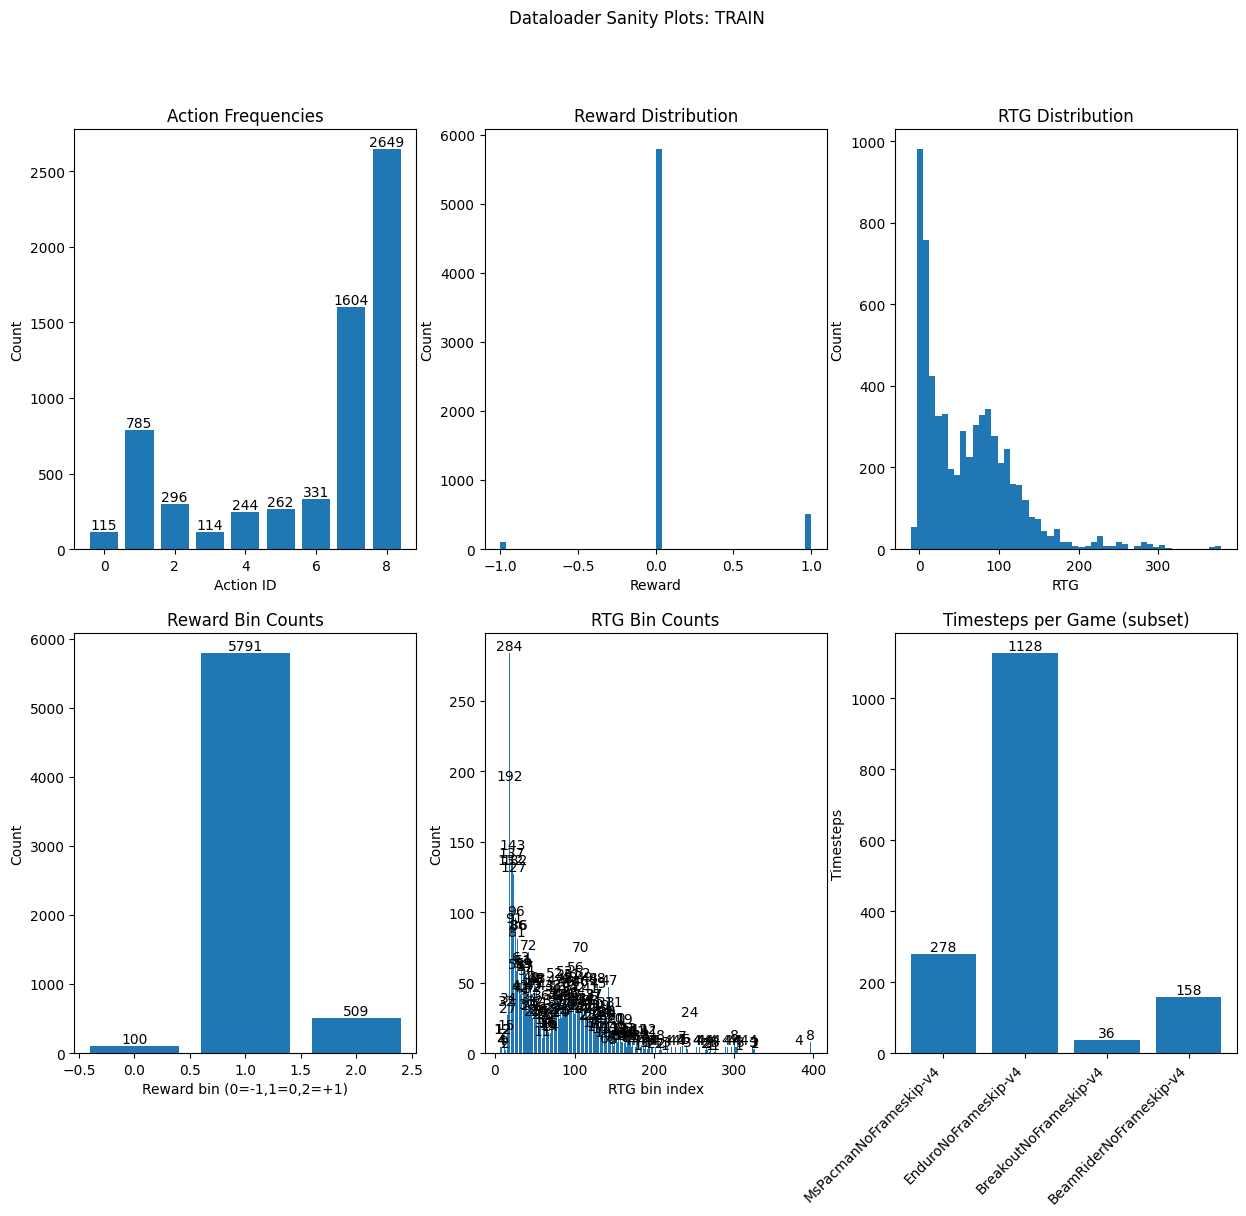

=== Dataloader Sanity Check: VAL ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 1 -> {'EnduroNoFrameskip-v4': 1600}
Actions: min=1, max=8, unique=7
Rewards: min=-1.000, max=1.000
RTG: min=93.000, max=130.000
Reward bins: unique=[0 1 2]
RTG bins: min=111, max=148
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'EnduroNoFrameskip-v4': 1600}, 'actions_min': 1.0, 'actions_max': 8.0, 'n_unique_actions': 7, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': 93.0, 'rtg_max': 130.0, 'reward_bins_unique': array([0, 1, 2]), 'rtg_bins_min': 111, 'rtg_bins_max': 148}


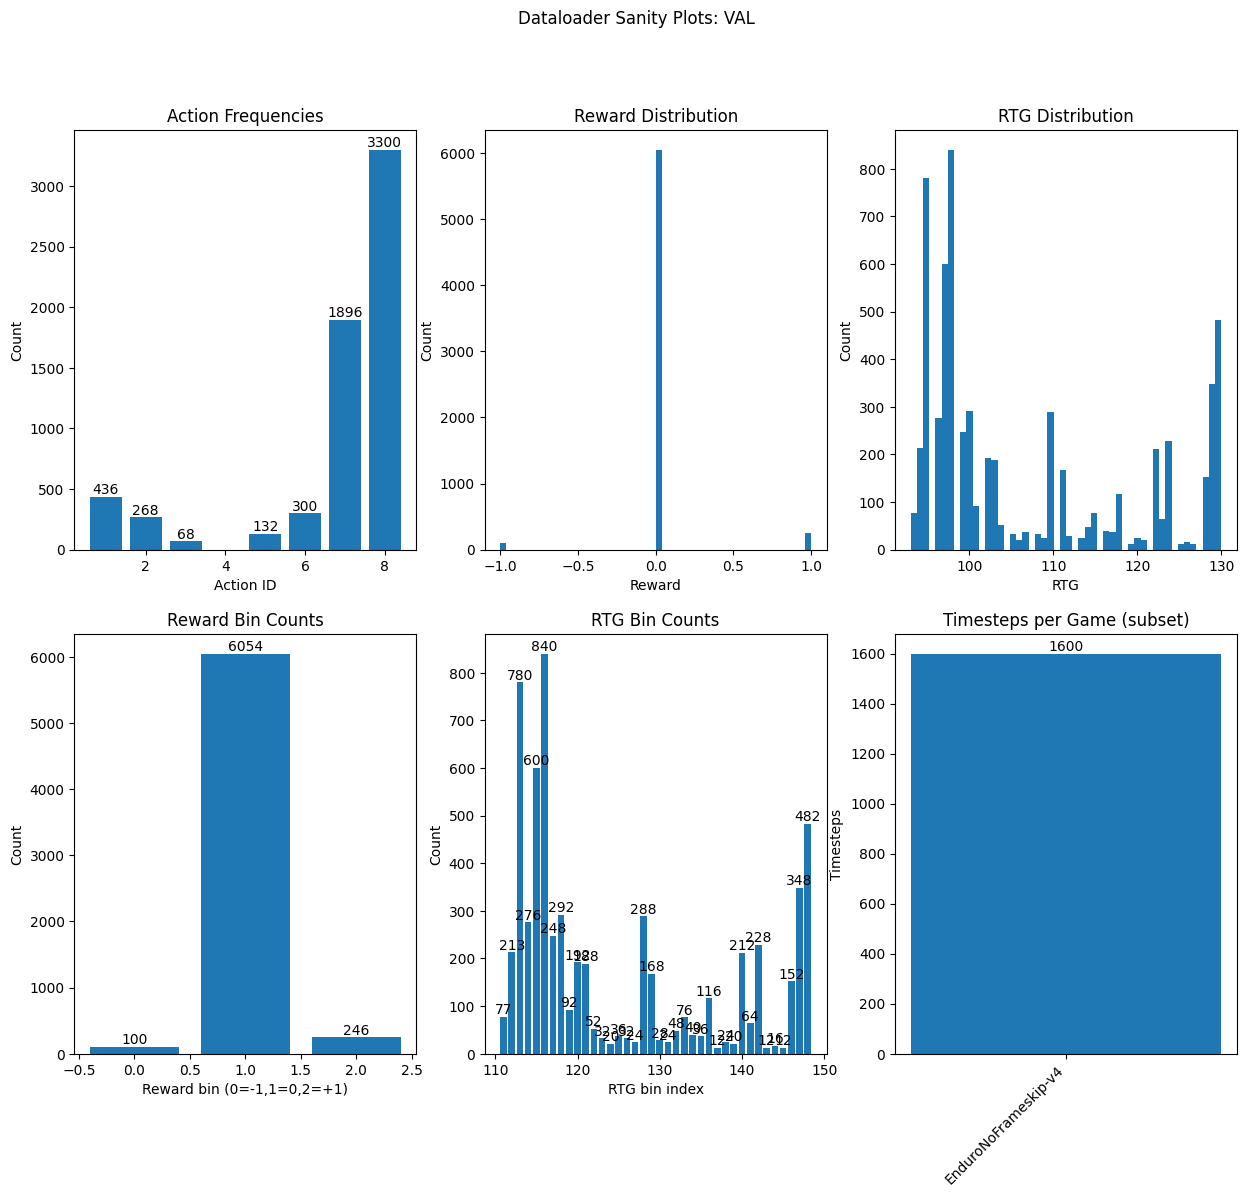

In [6]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(train_loader, "TRAIN")
inspect_dataloader(val_loader, "VAL")

# Train

In [7]:
from mgdt_model_trainer import Encoder, train_mgdt

model, train_stats, val_stats = train_mgdt(
    bins=bins,
    dataloader_train=train_loader,
    dataloader_val=val_loader,
    encoder_type=Encoder.Patch,
)

Validation: 100%|██████████| 660/660 [00:26<00:00, 24.70it/s]


# Look at Results

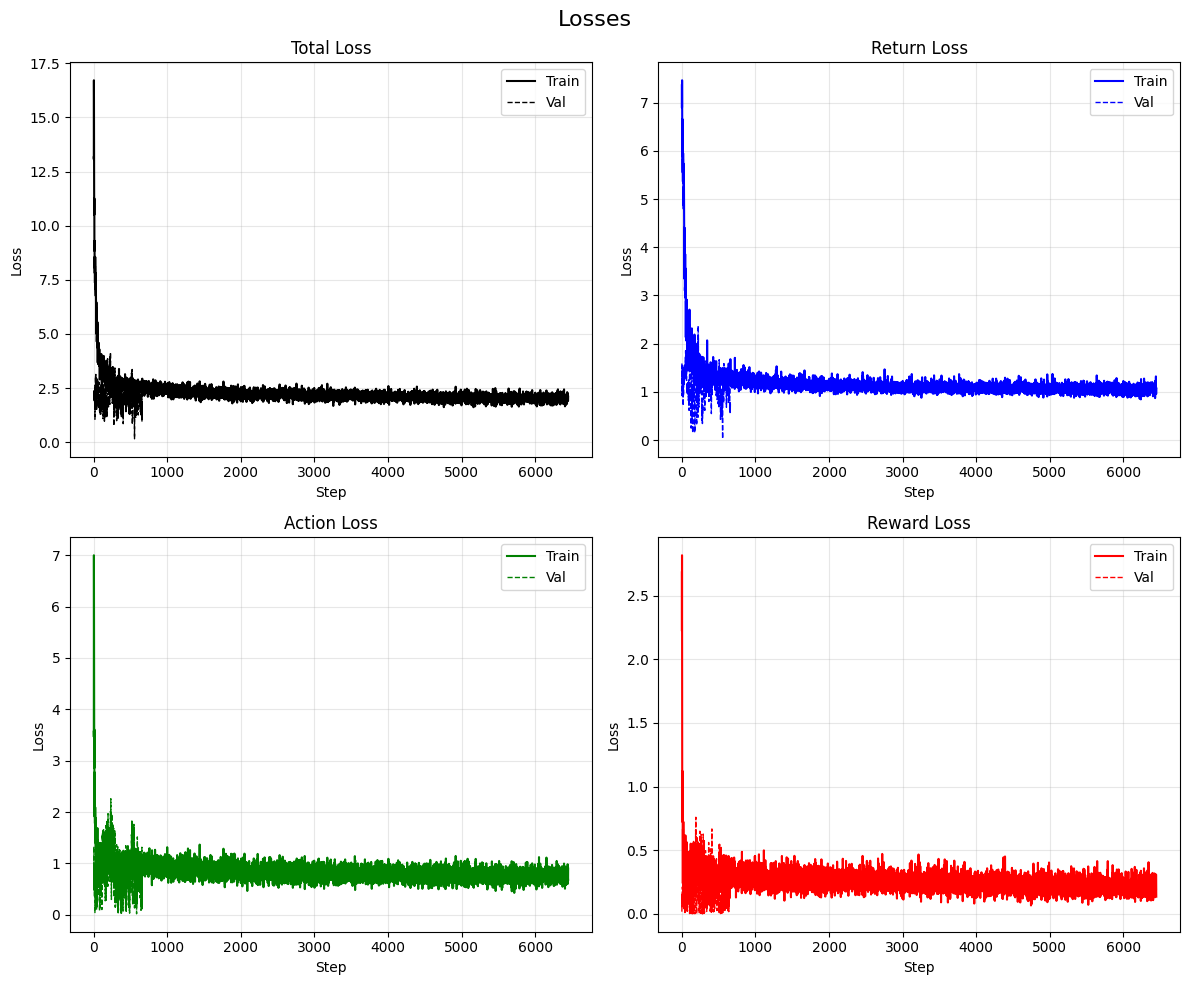

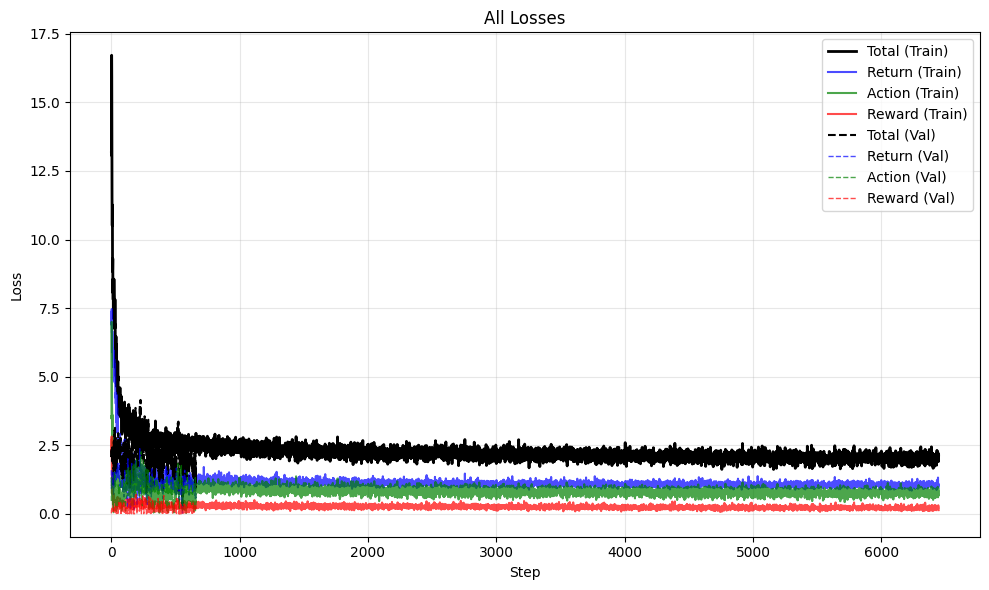

In [8]:
from mgdt_model_stats import plot_losses
plot_losses(train_stats, val_stats)

In [9]:
train_stats[:10]

[{'step': 1,
  'loss': 13.156068801879883,
  'loss_return': 6.908659934997559,
  'loss_action': 3.563811779022217,
  'loss_reward': 2.6835975646972656,
  'grad_norm': 1.0000000122992465,
  'return_acc': 0.0234375,
  'action_acc': 0.3359375,
  'reward_acc': 0.90625},
 {'step': 2,
  'loss': 13.067224502563477,
  'loss_return': 7.380688667297363,
  'loss_action': 3.464064836502075,
  'loss_reward': 2.222470998764038,
  'grad_norm': 0.9999999882067075,
  'return_acc': 0.0,
  'action_acc': 0.1640625,
  'reward_acc': 0.8984375},
 {'step': 3,
  'loss': 16.71841049194336,
  'loss_return': 6.899989604949951,
  'loss_action': 7.000472068786621,
  'loss_reward': 2.817948341369629,
  'grad_norm': 1.0000000123422177,
  'return_acc': 0.125,
  'action_acc': 0.1484375,
  'reward_acc': 0.8828125},
 {'step': 4,
  'loss': 15.903125762939453,
  'loss_return': 7.464298248291016,
  'loss_action': 6.448895454406738,
  'loss_reward': 1.9899320602416992,
  'grad_norm': 1.0000000576524668,
  'return_acc': 0.031

In [10]:
val_stats[:10]

[{'step': 1,
  'loss': 2.076184034347534,
  'loss_return': 1.5891892910003662,
  'loss_action': 0.47019603848457336,
  'loss_reward': 0.016798842698335648,
  'return_acc': 0.75,
  'action_acc': 0.7890625,
  'reward_acc': 1.0},
 {'step': 2,
  'loss': 2.3842921257019043,
  'loss_return': 0.9206912517547607,
  'loss_action': 1.3267807960510254,
  'loss_reward': 0.13682016730308533,
  'return_acc': 0.78125,
  'action_acc': 0.4921875,
  'reward_acc': 0.9375},
 {'step': 3,
  'loss': 2.396923542022705,
  'loss_return': 1.4273531436920166,
  'loss_action': 0.8389818668365479,
  'loss_reward': 0.13058853149414062,
  'return_acc': 0.75,
  'action_acc': 0.703125,
  'reward_acc': 0.9765625},
 {'step': 4,
  'loss': 2.071255922317505,
  'loss_return': 1.507816195487976,
  'loss_action': 0.5068201422691345,
  'loss_reward': 0.05661966651678085,
  'return_acc': 0.75,
  'action_acc': 0.703125,
  'reward_acc': 0.9921875},
 {'step': 5,
  'loss': 2.1045446395874023,
  'loss_return': 0.9711292386054993,
  

In [11]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

Total parameters: 20M


In [12]:
import pickle
from pathlib import Path

# Save model to file
model_path = Path("output/model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"Model saved to {model_path}")

Model saved to output\model.pkl
